# Simple Bayesian network

In [1]:
from simple_bayesiannetwork import *
import numpy as np
import common as c
import matplotlib.pyplot as plt

## Generate training data

First I'll generate some data using the true Bayesian network. The CPTs are chosen manually randomly. For the Bernouilli distribution I use a one-in-K coding scheme as means. This will allow for easy training.

In [2]:
# Number of data points
numN = 1000

# Define true model
cfg = c.Cfg()
cfg.A1 = np.array([0.2, 0.8])
cfg.A2 = np.array([[0.7, 0.3], [0.5, 0.5]])
cfg.A3 = np.array([[[0.1, 0.9], [1/3, 2/3]], [[1/3, 2/3], [0.9, 0.1]]])
cfg.mu = np.eye(8).reshape((2, 2, 2, 8))

model0 = Model(cfg)

# Generate data
X = model0.generate_data(numN)

# Display some data
X[0:10, :]

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

## Train a new Bayesian network

### Initialize new network with random parameters

In [3]:
cfg = c.Cfg()
cfg.A1 = generate_random_probability_matrix((2))
cfg.A2 = generate_random_probability_matrix((2, 2))
cfg.A3 = generate_random_probability_matrix((2, 2, 2))
cfg.mu = np.random.random((2, 2, 2, 8))

model = Model(cfg)

### Learn using EM algorithm

In [4]:
numEpochs = 50

log = c.Empty()
log.ll = np.zeros(numEpochs)
log.A1 = np.zeros((numEpochs, 2))
log.A2 = np.zeros((numEpochs, 2, 2))
log.A3 = np.zeros((numEpochs, 2, 2, 2))
log.mu = np.zeros((numEpochs, 2, 2, 2, 8))

for iEpoch in range(0, numEpochs):
    log.A1[iEpoch, :] = model.A1
    log.A2[iEpoch, :, :] = model.A2
    log.A3[iEpoch, :, :, :] = model.A3
    log.mu[iEpoch, :, :, :, :] = np.copy(model.mu)

    (p, ll) = model.infer(X)
    log.ll[iEpoch] = ll

    model.learn(p, X)

## Inspect results

### Data log-likelihood $P(X)$ over epochs

Averaged, rather than summed, over data points

Text(0, 0.5, 'average log P(X)')

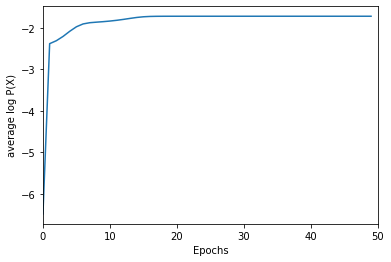

In [5]:
plt.figure()
plt.plot(log.ll); plt.xlim(0, numEpochs)
plt.xlabel('Epochs')
plt.ylabel('average log P(X)')

## Model parameters over epochs

Text(0.5, 0, 'Epochs')

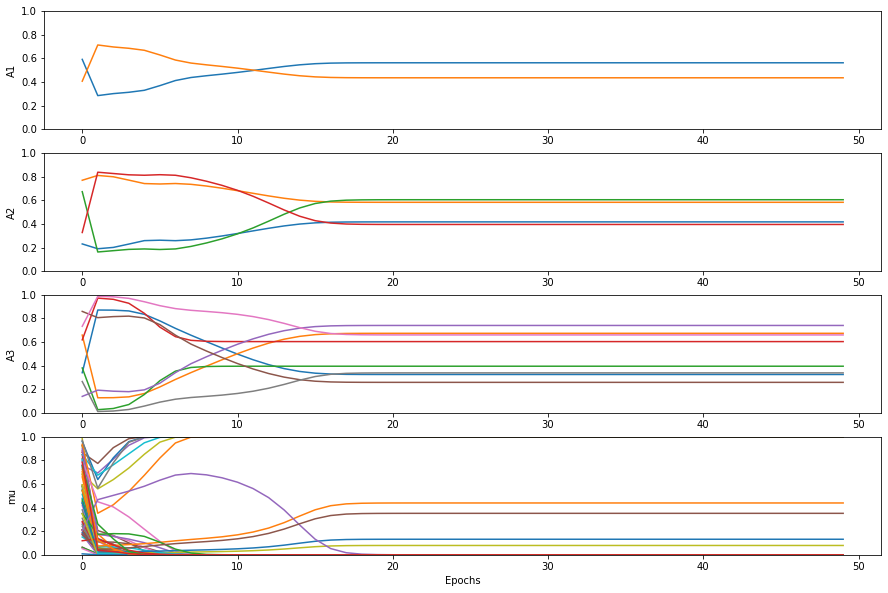

In [6]:
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1); plt.plot(log.A1.reshape((numEpochs, -1))); plt.ylim([0, 1]); plt.ylabel('A1')
plt.subplot(4, 1, 2); plt.plot(log.A2.reshape((numEpochs, -1))); plt.ylim([0, 1]); plt.ylabel('A2')
plt.subplot(4, 1, 3); plt.plot(log.A3.reshape((numEpochs, -1))); plt.ylim([0, 1]); plt.ylabel('A3')
plt.subplot(4, 1, 4); plt.plot(log.mu.reshape((numEpochs, -1))); plt.ylim([0, 1]); plt.ylabel('mu')
plt.xlabel('Epochs')

## Inspection of final parameters

### mu - $\mu_{lijk}$

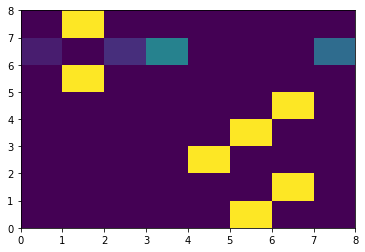

In [7]:
plt.figure()
plt.pcolormesh(model.mu.reshape((-1, 8)), vmin=0, vmax=1)

### A1 - $P(Q^1)$

In [8]:
print(f'True model, A1:\n{model0.A1}')
print(f'Trained model, A1:\n{model.A1}')

True model, A1:
[0.2 0.8]
Trained model, A1:
[0.56348728 0.43651272]


### A2 - $P(Q^2 | Q^1)$

In [9]:
print(f'True model, A2:\n{model0.A2}')
print(f'Trained model, A2:\n {model.A2}')

True model, A2:
[[0.7 0.3]
 [0.5 0.5]]
Trained model, A2:
 [[0.41714477 0.58285523]
 [0.60466616 0.39533384]]


### A3 - $P(Q^3 | Q^1, Q^2)$

In [10]:
print(f'True model, A3:\n{model0.A3}')
print(f'Trained model, A3:\n {model.A3}')

True model, A3:
[[[0.1        0.9       ]
  [0.33333333 0.66666667]]

 [[0.33333333 0.66666667]
  [0.9        0.1       ]]]
Trained model, A3:
 [[[0.32574585 0.67425415]
  [0.39582066 0.60417934]]

 [[0.74073402 0.25926598]
  [0.66060875 0.33939125]]]


## Intermediate conclusions

- The data log-likelihood increases with epochs, suggesting that the algorithm is implemented correctly
- The learned A1 and A2 parameters match quite well with the true model. A3 and mu are sensible too, though do not not match exactly with the true model

# Sanity checks

## Continuous increase in data log-likelihood?

The EM algorithm guarantees that the log-likelihood should increase with every epoch. Thus, a first sanity check as to whether I implemented the algorithm is to verify whether this is the case.

Text(0, 0.5, 'll increase?')

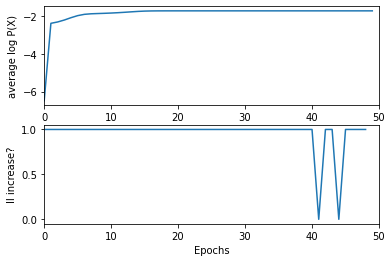

In [11]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(log.ll); 
plt.xlim(0, numEpochs)
plt.ylabel('average log P(X)')

ll_diff = log.ll[1:] - log.ll[:-1]
ll_increase = ll_diff >= 0
plt.subplot(2, 1, 2); 
plt.plot(ll_increase); 
plt.xlim(0, numEpochs)
plt.xlabel('Epochs')
plt.ylabel('ll increase?')

The log-likelihood does not seem to increase with every epoch. Let's inspect.

In [12]:
index = np.where(ll_increase == False)[0][0]

print(f'Violating ll difference: {ll_diff[index]} at index: {index}')

Violating ll difference: -4.440892098500626e-16 at index: 41


In [13]:
inspect_range = range(max(0, index-10), min(numEpochs-1, index+10))

print(f'Range around violating difference:\n{ll_diff[inspect_range]}')

Range around violating difference:
[ 3.40245609e-11  9.92228522e-12  2.89301916e-12  8.39106562e-13
  2.44693155e-13  7.43849426e-14  1.95399252e-14  8.21565038e-15
  4.44089210e-16  8.88178420e-16 -4.44089210e-16  2.22044605e-16
  2.22044605e-16 -4.44089210e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


It seems that the increase has simply come to a halt. At later epochs the difference in LL is 0. The negative number is extremely small, and therefore most likely a numerical error.

## Start training with true model

If the algorithm is implemented correctly, then starting with the true model should result in no change in parameters, since the parameters are already optimal for the data by definition.

In [14]:
cfg = c.Cfg()
cfg.A1 = model0.A1
cfg.A2 = model0.A2
cfg.A3 = model0.A3
cfg.mu = model0.mu * 0.999999 + 0.0000005   # Normalize to avoid log(0)

model = Model(cfg)

numEpochs = 50

log = c.Empty()
log.ll = np.zeros(numEpochs)
log.A1 = np.zeros((numEpochs, 2))
log.A2 = np.zeros((numEpochs, 2, 2))
log.A3 = np.zeros((numEpochs, 2, 2, 2))
log.mu = np.zeros((numEpochs, 2, 2, 2, 8))

for iEpoch in range(0, numEpochs):
    log.A1[iEpoch, :] = model.A1
    log.A2[iEpoch, :, :] = model.A2
    log.A3[iEpoch, :, :, :] = model.A3
    log.mu[iEpoch, :, :, :, :] = np.copy(model.mu)

    (p, ll) = model.infer(X)
    log.ll[iEpoch] = ll

    model.learn(p, X)

### Log-likelhood

Text(0, 0.5, 'average log P(X)')

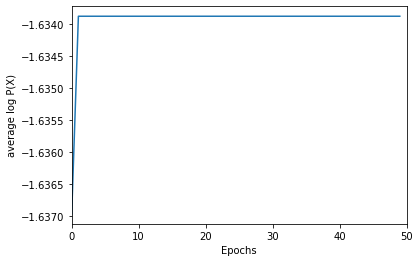

In [15]:
plt.figure()
plt.plot(log.ll); plt.xlim(0, numEpochs)
plt.xlabel('Epochs')
plt.ylabel('average log P(X)')

### Parameters

Text(0.5, 0, 'Epochs')

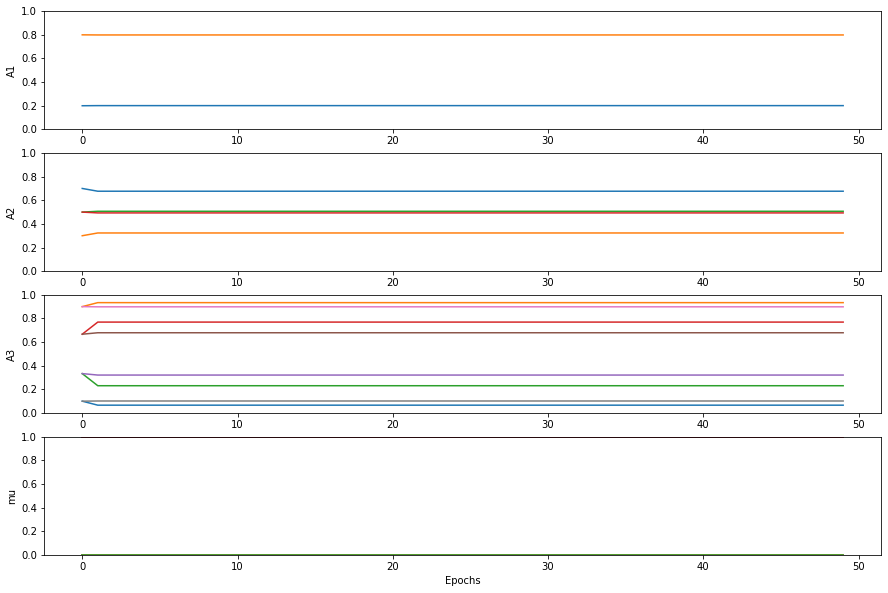

In [16]:
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1); plt.plot(log.A1.reshape((numEpochs, -1))); plt.ylim([0, 1]); plt.ylabel('A1')
plt.subplot(4, 1, 2); plt.plot(log.A2.reshape((numEpochs, -1))); plt.ylim([0, 1]); plt.ylabel('A2')
plt.subplot(4, 1, 3); plt.plot(log.A3.reshape((numEpochs, -1))); plt.ylim([0, 1]); plt.ylabel('A3')
plt.subplot(4, 1, 4); plt.plot(log.mu.reshape((numEpochs, -1))); plt.ylim([0, 1]); plt.ylabel('mu')
plt.xlabel('Epochs')

### Intermediate conclusion

The log-likelihood and the parameters only change at the first iteration. This is because the data is finite. While the true model does indeed have the perfect parameters for the data, the actual sampled data does not perfectly reflect the true model. The minor change seen in these results is overfitting to these particularly drawn data.

# Conclusion

The model seems to be implemented correctly and is able to quite accurately recover the true model's parameters.

Some caution is still in place however with the log-likelihood decreasing for some epochs. While it usually seems to be numerical errors, I have also come across instances where the negative values were not extremely small. There might still be an error in the implementation.